In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch import optim
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# !pip install torchvision
import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# !pip install torchmetrics
import torchmetrics

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [2]:
# 載入數據
#訓練集weights_only用False
images = torch.load("/kaggle/input/moai-2025-training/train_images.pt", weights_only = False)
labels = pd.read_csv("/kaggle/input/moai-2025-training/train_labels.csv")

# 歸一化
images = images.float()
images = (images - images.min()) / images.max()

# 將labels變為tensor類型
labels = torch.tensor(labels["label"].values)

#合并為一個數據集
dataset = TensorDataset(images, labels)

# 劃分數據集
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 轉換為dataloader
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64)

#for x, y in train_loader:
    #print(x.shape) 發現缺少Channel
#for i in range(5):
    #print(images[i])
print(images.shape) #[60000, 28, 28] 60000個28*28樣本

torch.Size([60000, 28, 28])


In [3]:
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.Model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, padding = 1), # [16, 28, 28] channel, h, w
            nn.ReLU(),
            nn.MaxPool2d(2), # [16, 14, 14]
            nn.Conv2d(16, 32, kernel_size = 3, padding = 1), # [32, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2), # [32, 7, 7]
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1), # [64, 7, 7]
            nn.ReLU(),
            nn.Flatten(), #展平
            nn.Linear(64 * 7 * 7, 100),
            nn.Linear(100, 10),
            nn.Softmax()
        )
    def forward(self, x):
        x = x.view(-1, 1, 28, 28) #補上channel(1) 標準格式 : [N, C, H , W]
        #N是批次個數, 通常是batch_size, C是channel，黑白是1，彩色是3。H是高，W是寬。
        # -1代表自動設batch_size(因為有時侯不夠)
        return self.Model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn().to(device)
print(model)

cnn(
  (Model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=3136, out_features=100, bias=True)
    (10): Linear(in_features=100, out_features=10, bias=True)
    (11): Softmax(dim=None)
  )
)


In [4]:
loss_function = nn.CrossEntropyLoss() # 多分類問題用的Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) #使用adam優化器, 學習率為3e-4

scheduler = lr_scheduler.ReduceLROnPlateau( #自動調學習率
    optimizer, 
    mode = 'min', # 監控驗證損失
    factor =0.1,  # 學習率衰減係數
    patience = 5, # 容忍n個epoch無改善
    verbose = True, # 打印調整日誌
    min_lr = 3e-4 # 最小學習率
)

train_loss_list = []
val_loss_list = []
sample = 0
for x in range(20):
    model.train() #進入訓練模式
    train_loss = 0
    for batch_i, (img, lab) in enumerate(train_loader): #每一次循環會返回索引和數據
        optimizer.zero_grad() #清空先前累積的梯度
        img = img.to(device)
        lab = lab.to(device)
        #將img和lab移動到先前指定的計算設備
        outputs = model(img)
        loss = loss_function(outputs, lab) #計算loss
        loss.backward() #用反向傳播計算梯度
        optimizer.step() #更新Weight
        pred = outputs.argmax(dim = 1) #dim = 1代表批次中的每個樣本中的10個類別選擇最高分的索引 (橫看)
        #dim = 0是縱看
        train_loss += float(loss) * img.size(0) #將loss由tensor變回float方便進行運算
        sample += img.size(0)
        train_acc = accuracy_score(lab.numpy(), pred.numpy()) #必須使用cpu和numpy陣列 / list
    average_train_loss = float(train_loss / sample)
    train_loss_list.append(average_train_loss)
    print(f"Epoch {x + 1}, Batch {batch_i}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_acc * 100:.2f}%")
    
    model.eval()

    val_pred = []
    val_lab = []
    val_loss = 0
    sample = 0
    average_val_loss = 0
    with torch.no_grad(): #關掉梯度計算
        for img, lab in val_loader:
            img = img.to(device)
            outputs = model(img)
            val_pred.extend(outputs.argmax(dim = 1).cpu().numpy()) #將所有pred合在一起
            val_lab.extend(lab.numpy())
            loss_temp = loss_function(outputs, lab)
            val_loss += float(loss_temp) * img.size(0) # img.size(0)是當前batch的size
            sample += img.size(0)
    val_acc = accuracy_score(val_lab, val_pred)
    average_val_loss = float(val_loss / sample)
    val_loss_list.append(average_val_loss)
    scheduler.step(average_val_loss)
    print(f"Epoch {x + 1}, Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_acc * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 1, Batch 749, Train Loss: 1.6581, Train Accuracy: 93.75%
Epoch 1, Val Loss: 1.5317, Val Accuracy: 93.35%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 2, Batch 749, Train Loss: 1.2091, Train Accuracy: 90.62%
Epoch 2, Val Loss: 1.5001, Val Accuracy: 96.39%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 3, Batch 749, Train Loss: 1.1943, Train Accuracy: 95.31%
Epoch 3, Val Loss: 1.4846, Val Accuracy: 97.90%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 4, Batch 749, Train Loss: 1.1887, Train Accuracy: 100.00%
Epoch 4, Val Loss: 1.4810, Val Accuracy: 98.09%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 5, Batch 749, Train Loss: 1.1851, Train Accuracy: 100.00%
Epoch 5, Val Loss: 1.4784, Val Accuracy: 98.36%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 6, Batch 749, Train Loss: 1.1829, Train Accuracy: 96.88%
Epoch 6, Val Loss: 1.4770, Val Accuracy: 98.58%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 7, Batch 749, Train Loss: 1.1807, Train Accuracy: 98.44%
Epoch 7, Val Loss: 1.4734, Val Accuracy: 98.83%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 8, Batch 749, Train Loss: 1.1793, Train Accuracy: 98.44%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 8, Val Loss: 1.4742, Val Accuracy: 98.78%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 9, Batch 749, Train Loss: 1.1790, Train Accuracy: 96.88%
Epoch 9, Val Loss: 1.4796, Val Accuracy: 98.18%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 10, Batch 749, Train Loss: 1.1773, Train Accuracy: 98.44%
Epoch 10, Val Loss: 1.4718, Val Accuracy: 98.98%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 11, Batch 749, Train Loss: 1.1768, Train Accuracy: 100.00%
Epoch 11, Val Loss: 1.4747, Val Accuracy: 98.67%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 12, Batch 749, Train Loss: 1.1764, Train Accuracy: 100.00%
Epoch 12, Val Loss: 1.4732, Val Accuracy: 98.87%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 13, Batch 749, Train Loss: 1.1754, Train Accuracy: 100.00%
Epoch 13, Val Loss: 1.4706, Val Accuracy: 99.10%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 14, Batch 749, Train Loss: 1.1752, Train Accuracy: 96.88%
Epoch 14, Val Loss: 1.4709, Val Accuracy: 99.04%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 15, Batch 749, Train Loss: 1.1752, Train Accuracy: 100.00%
Epoch 15, Val Loss: 1.4720, Val Accuracy: 98.93%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 16, Batch 749, Train Loss: 1.1749, Train Accuracy: 98.44%
Epoch 16, Val Loss: 1.4728, Val Accuracy: 98.87%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 17, Batch 749, Train Loss: 1.1743, Train Accuracy: 100.00%
Epoch 17, Val Loss: 1.4710, Val Accuracy: 98.99%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 18, Batch 749, Train Loss: 1.1737, Train Accuracy: 100.00%
Epoch 18, Val Loss: 1.4723, Val Accuracy: 98.90%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 19, Batch 749, Train Loss: 1.1738, Train Accuracy: 100.00%
Epoch 19, Val Loss: 1.4706, Val Accuracy: 99.08%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules

Epoch 20, Batch 749, Train Loss: 1.1735, Train Accuracy: 98.44%
Epoch 20, Val Loss: 1.4728, Val Accuracy: 98.89%


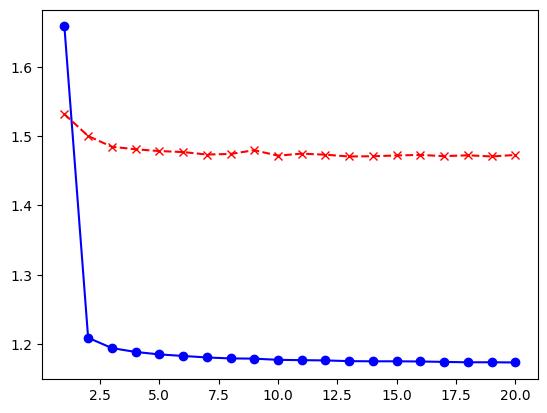

In [5]:
epochs = range(1, 21)
plt.plot(epochs, train_loss_list, marker='o', linestyle='-', color='b', label='Train Loss')  # 繪製訓練集損失曲線
plt.plot(epochs, val_loss_list, marker='x', linestyle='--', color='r', label='Validation Loss')  
plt.show()

In [6]:
#測試集weights_only用True
test_images = torch.load("/kaggle/input/moai-2025-training/test_images.pt", weights_only = True)

test_images = test_images.float()
tset_images = (test_images - test_images.min()) / test_images.max()

model.eval()
with torch.no_grad():
    test_images = test_images.to(device)
    outputs = model(test_images)
    pred = outputs.argmax(dim = 1)
    
df_test = pd.DataFrame({"label": pred.cpu().numpy()}) #一定要用cpu及numpy / list
df_test.to_csv("submission.csv", index_label="id")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
